# Train a VAE on L1000 Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data, infer_L1000_features
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA

from tensorflow import keras


from vae import VAE
from tensorflow.keras.models import Model, Sequential
import seaborn
import tensorflow as tf


In [3]:
def remove_moa(df):
    pipes = ['AKT inhibitor|mTOR inhibitor',
            'CDK inhibitor|glycogen synthase kinase inhibitor',
            'cytochrome P450 inhibitor|protein synthesis inhibitor',
            'benzodiazepine receptor agonist|HDAC inhibitor',
            'thromboxane receptor antagonist|thromboxane synthase inhibitor']  
    moas =  []
    for pipe in pipes:
        moas.append(pipe)
        moas.append(pipe.split('|')[0])
        moas.append(pipe.split('|')[1])
    return df[~df.moa.isin(moas)]

In [4]:
data_splits = ["train", "valid", "test", "complete"]
data_dict = load_data(data_splits, dataset="L1000")

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
# Prepare data for training
meta_features = infer_L1000_features(data_dict["train"], metadata=True)
profile_features = infer_L1000_features(data_dict["train"])

moa_df_train = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_id').reindex(index=data_dict['train']['pert_id']).reset_index().drop('pert_id',axis = 1)
data_dict['train'] = pd.concat([moa_df_train,data_dict['train']], axis=1)

moa_df_valid = pd.read_csv("../3.application/repurposing_info_external_moa_map_resolved.tsv",sep='\t').set_index('broad_id').reindex(index=data_dict['valid']['pert_id']).reset_index().drop('pert_id',axis = 1)
data_dict['valid'] = pd.concat([moa_df_valid,data_dict['valid']], axis=1)

data_dict['train'] = remove_moa(data_dict['train'])
data_dict['valid'] = remove_moa(data_dict['valid'])

train_features_df = data_dict["train"].reindex(profile_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(profile_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(profile_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(profile_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [6]:
#shuffle columns
def shuffle_each_column(df):
    columns = df.columns
    df_copy = df.copy()
    for column in columns:
        df_copy[column] = df_copy[column].sample(frac=1).reset_index(drop=True)
    return (df_copy)

In [7]:
print(train_features_df.shape)
train_features_df.head(3)

(90735, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.74578,-0.007757,-0.063908,-0.11521,0.83776,-0.80023,-0.25787,-0.62118,-0.533130,-0.260430,...,-0.458550,0.51684,2.86550,-0.15221,-0.907810,1.47600,-0.42918,-0.81612,0.28533,0.37183
1,-0.29710,-0.180930,0.482090,-0.33713,-0.47045,-0.44483,0.38475,-0.56639,0.277260,0.000645,...,0.008161,-0.33238,-0.20174,-0.60539,0.024792,0.60759,0.41555,0.50640,0.23908,-0.23696
3,0.20702,-3.430300,2.470000,1.30480,-0.36689,-2.14630,-0.32963,0.29220,0.003512,0.438560,...,0.809730,1.29560,1.23240,2.62050,-0.431080,0.41413,-0.74994,0.33455,0.50422,1.59840


In [8]:
print(valid_features_df.shape)
valid_features_df.head(3)

(11315, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,-0.534400,0.552700,0.000000,-0.95760,-0.3264,-0.25560,0.00000,0.00000,1.88250,1.86290,...,5.22050,-0.96970,-1.133800,-1.079700,-2.29810,0.8493,0.29560,0.84640,0.19020,-0.47540
1,-0.029159,0.039928,0.045024,0.26740,-1.0234,0.58926,0.57561,0.60793,0.33281,-0.65153,...,-0.25789,0.46169,0.022211,-0.035998,0.67575,2.2909,0.24359,-0.14676,-0.84884,-0.16919
2,0.365290,-1.311300,-0.153500,0.72378,-1.1094,-0.38681,1.05910,0.12169,-1.01300,0.83094,...,-0.22982,-0.21314,-0.088198,0.527700,0.49855,-1.3877,1.00980,-0.21835,0.16329,-0.79029


In [9]:
print(test_features_df.shape)
test_features_df.head(3)

(11805, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.28158,1.6038,-1.58650,-0.41677,-2.34260,3.12320,-0.10233,1.62600,0.115840,-0.000233,...,-0.49069,-1.14930,-0.16539,0.49864,1.077800,1.66230,-1.66900,-0.49738,0.51629,1.08940
1,0.77369,1.0853,0.75758,1.04900,1.18270,0.69324,-0.43503,-0.88949,-0.075833,0.208990,...,0.10747,0.97814,0.85407,0.10528,-0.370430,0.89069,-0.26969,-0.98646,-1.07350,0.48240
2,0.63079,1.9072,-1.65190,0.26266,0.68423,-0.38400,1.63160,0.78741,0.732920,-2.431700,...,-1.83770,-0.56064,0.93692,0.96585,-0.036786,1.35430,2.15870,-0.28158,0.53111,-0.46053


In [10]:
print(complete_features_df.shape)
complete_features_df.head(3)

(118050, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,4.26410,0.057249,-2.13930,-0.22178,-0.37656,1.91380,0.065576,-0.86895,-0.10227,0.00000,...,5.246200,0.057058,-1.25620,-0.025255,0.168860,-1.639100,0.68510,-0.41942,1.71610,-0.47234
1,-0.38221,0.304310,-0.99592,-0.67083,-0.64824,0.62161,0.889530,0.20376,0.19481,-0.45637,...,0.206690,-0.010866,-0.87206,-0.223750,0.074144,0.093595,0.32667,1.04810,-0.50518,-0.61832
2,-0.57171,-0.755000,-0.71011,0.42889,0.27261,0.31436,-1.545800,0.64195,-0.87685,0.00000,...,-0.005612,1.194500,0.17111,0.334370,-1.089300,-0.114640,0.30483,-0.24947,-0.42835,1.58500


In [1]:

encoder_architecture = [500]
decoder_architecture = [500]


In [12]:

L1000_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=65,
    batch_size=512,
    encoder_batch_norm=True,
    epochs=30,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=0,
    lam=10000000,
    verbose=True,
)

L1000_vae.compile_vae()

In [13]:
L1000_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/30
178/178 [==============================] - 27s 136ms/step - loss: 10008.3281 - recon: 1705.0929 - kl: 0.0000e+00 - mmd: 4611.4717 - val_loss: 3498.5940 - val_recon: 1626.4341 - val_kl: 0.0000e+00 - val_mmd: 2381.5425
Epoch 2/30
178/178 [==============================] - 23s 131ms/step - loss: 3179.1726 - recon: 1595.3142 - kl: 0.0000e+00 - mmd: 1437.0546 - val_loss: 2982.1086 - val_recon: 1567.5999 - val_kl: 0.0000e+00 - val_mmd: 1777.9808
Epoch 3/30
178/178 [==============================] - 23s 131ms/step - loss: 2818.1157 - recon: 1544.3044 - kl: 0.0000e+00 - mmd: 1241.3839 - val_loss: 2845.0793 - val_recon: 1516.2754 - val_kl: 0.0000e+00 - val_mmd: 1757.5077
Epoch 4/30
178/178 [==============================] - 23s 131ms/step - loss: 2705.2811 - recon: 1506.6526 - kl: 0.0000e+00 - mmd: 1243.0914 - val_loss: 2709.9182 - val_recon: 1485.1820 - val_kl: 0.0000e+00 - val_mmd: 1618.2404
Epoch 5/30
178/178 [==============================] - 23s 132ms/step - loss: 2692.0608 - re

In [14]:
L1000_vae.vae

In [15]:
# Save training performance
history_df = pd.DataFrame(L1000_vae.vae.history.history)
history_df


,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,6288.556152,1705.092896,0.0,4611.471680,3498.593994,1626.434082,0.0,2381.542480
1,3025.976807,1595.314209,0.0,1437.054565,2982.108643,1567.599854,0.0,1777.980835
2,2779.630615,1544.304443,0.0,1241.383911,2845.079346,1516.275391,0.0,1757.507690
3,2692.536377,1506.652588,0.0,1243.091431,2709.918213,1485.182007,0.0,1618.240356
4,2663.979736,1485.997192,0.0,1214.046387,2829.075684,1463.713623,0.0,1780.624023
5,2686.442383,1469.885498,0.0,1228.116943,2709.141357,1448.287354,0.0,1852.305054
6,2650.918945,1450.994263,0.0,1211.581665,2772.861816,1427.894531,0.0,1814.468872
7,2615.401367,1434.439453,0.0,1200.604858,2803.220215,1423.459595,0.0,1630.213013
8,2585.123047,1420.014893,0.0,1211.320435,2629.745117,1406.399170,0.0,1747.556396
9,2578.778809,1403.102173,0.0,1186.621460,2596.868408,1394.725342,0.0,1614.767700


In [16]:
history_df.to_csv('twolayer_training_mmd_leaveOut.csv')

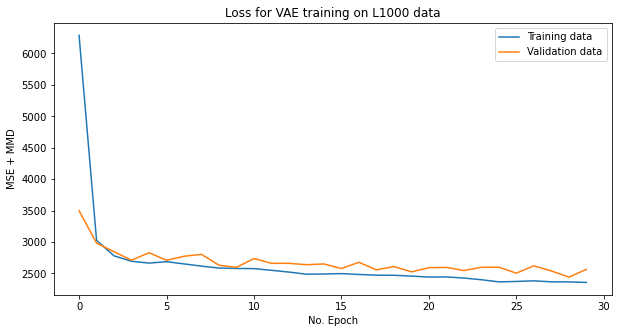

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on L1000 data")
plt.ylabel("MSE + MMD")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [18]:
# evaluating performance using test set
L1000_vae.vae.evaluate(test_features_df)

369/369 [==============================] - 1s 2ms/step - loss: 19943.4453 - recon: 1277.0674 - kl: 0.0000e+00 - mmd: 18242.8125


[19943.4453125, 1277.0673828125, 0.0, 18242.8125]

In [19]:
reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

3882.7005637573166

<AxesSubplot:>

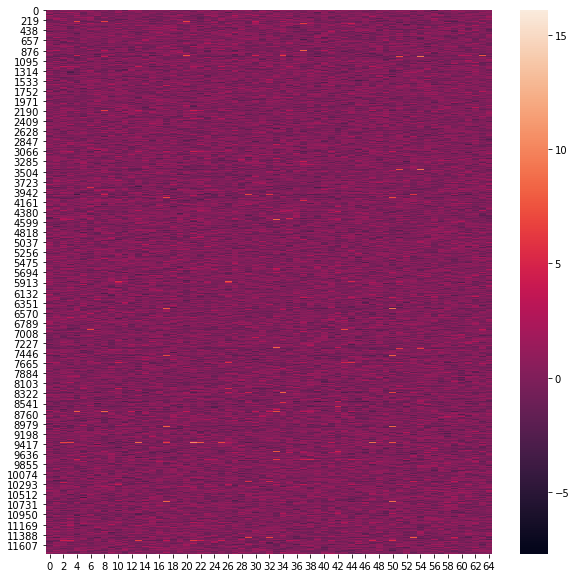

In [20]:
# latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = L1000_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [21]:


reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)

pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))


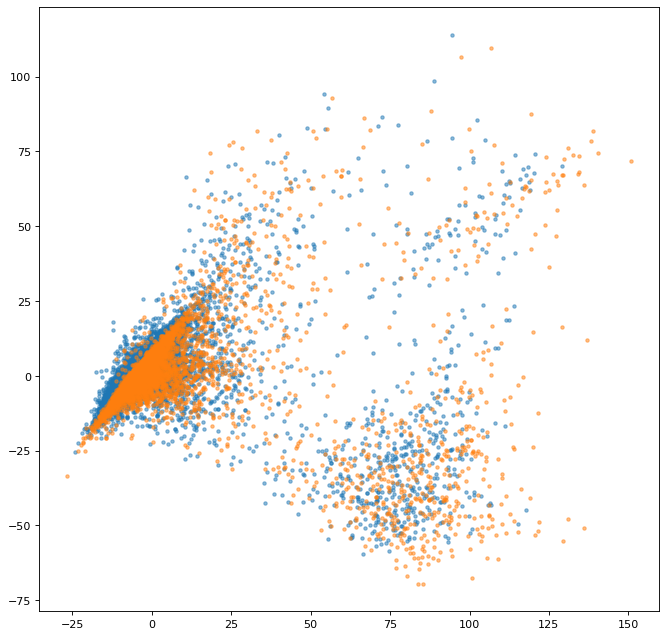

In [22]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)


In [28]:
decoder = L1000_vae.decoder_block["decoder"]


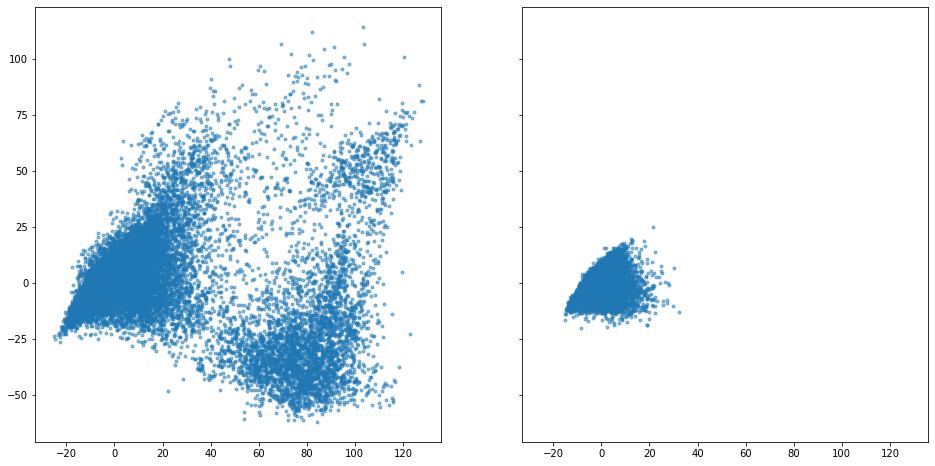

In [29]:
pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(94440, 65)), columns=np.arange(0,65))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [30]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

202.72491169248198

In [39]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/latentTwoLayer_mmd_leaveOut.csv")

In [37]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save('./models/L1000twolayerDecoder_mmd_leaveOut')

INFO:tensorflow:Assets written to: ./L1000twolayerDecoder_mmd_leaveOut/assets


In [38]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
encoder.save('./models/L1000twolayerEncoder_mmd_leaveOut')

INFO:tensorflow:Assets written to: ./L1000twolayerEncoder_mmd_leaveOut/assets
